## Corgie vehicle data PCA

#### Background
Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars.

#### Problem Statement
The purpose is to classify a given silhouette as one of three types of vehicles (bus/car/van), using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.

#### Steps:
The points distribution for this case is as follows:
1. Data pre-processing - Understand the data and treat missing values (Use box plot), outliers (5 points)
2. Understanding the attributes - Find relationship between different attributes (Independent variables) and choose carefully which all attributes have to be a part of the analysis and why (5 points)
3. Use PCA from scikit learn and elbow plot to find out reduced number of dimension (which covers more than 95% of the variance) - 10 points
4. Use Support vector machines (find references below and research out on how to create this model) and use grid search (try C values - 0.01, 0.05, 0.5, 1 and kernel = linear, rbf) and find out the best hyper parameters and do cross validation to find the accuracy. (10 points)

<hr/>

In [1]:
# Import required libraries 
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler

# Import model tuning 
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix  

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 

In [2]:
# To display all the variable values / full output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Ignore ipython warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load dataset
df = pd.read_csv('vehicle.csv')
df.shape

(846, 19)

In [4]:
df.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio class  
0             187.0            197   van  
1             189.0            199   van  
2             188.0            196   car  
3             199.0            207   van  
4             180.0            183   bus

In [5]:
df['class'].value_counts()

car    429
bus    218
van    199
Name: class, dtype: int64

In [6]:
# Encode the Class column since it has string value

le = LabelEncoder() 
df['class'] = le.fit_transform(df['class'])
df.shape
df['class'].value_counts()

(846, 19)

1    429
0    218
2    199
Name: class, dtype: int64

### EDA - Finding missing values

In [7]:
# Check null values
df = df.replace('?', np.nan)
df.isnull().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

In [8]:
# There are 33 null values, it can be either removed or filled with mean value.
# Filling the null value with mean
imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=1)

# Separate the independent and dependent values
X = df.drop('class', axis=1)
X_imputed = imputer.fit_transform(X)
X_imputed.shape

(846, 18)

In [9]:
df_modified = pd.DataFrame(X_imputed, columns = X.columns)
df_modified['class'] = df[['class']] # Putting back the target value in modified dataset
df_modified.isnull().sum()

compactness                    0
circularity                    0
distance_circularity           0
radius_ratio                   0
pr.axis_aspect_ratio           0
max.length_aspect_ratio        0
scatter_ratio                  0
elongatedness                  0
pr.axis_rectangularity         0
max.length_rectangularity      0
scaled_variance                0
scaled_variance.1              0
scaled_radius_of_gyration      0
scaled_radius_of_gyration.1    0
skewness_about                 0
skewness_about.1               0
skewness_about.2               0
hollows_ratio                  0
class                          0
dtype: int64

Observation: The null values are replaced with mean. there is no null in the dataset

### 2. Understanding the attributes
 Find relationship between different attributes (Independent variables) and choose carefully which all attributes have to be a part of the analysis and why

In [10]:
df_modified.describe().transpose()

count        mean         std    min     25%  \
compactness                  846.0   93.678487    8.234474   73.0   87.00   
circularity                  846.0   44.823877    6.134272   33.0   40.00   
distance_circularity         846.0   82.100473   15.741569   40.0   70.00   
radius_ratio                 846.0  168.874704   33.401356  104.0  141.00   
pr.axis_aspect_ratio         846.0   61.677305    7.882188   47.0   57.00   
max.length_aspect_ratio      846.0    8.567376    4.601217    2.0    7.00   
scatter_ratio                846.0  168.887707   33.197710  112.0  147.00   
elongatedness                846.0   40.936170    7.811882   26.0   33.00   
pr.axis_rectangularity       846.0   20.580378    2.588558   17.0   19.00   
max.length_rectangularity    846.0  147.998818   14.515652  118.0  137.00   
scaled_variance              846.0  188.596927   31.360427  130.0  167.00   
scaled_variance.1            846.0  439.314421  176.496341  184.0  318.25   
scaled_radius_of_gyration    846.0  174.706856   32.546277  109.0  149.00   
scaled_radius_of_gyration.1  846.0   72.443262    7.468734   59.0   67.00   
skewness_about               846.0    6.361702    4.903244    0.0    2.00   
skewness_about.1             846.0   12.600473    8.930962    0.0    5.00   
skewness_about.2             846.0  188.918440    6.152247  176.0  184.00   
hollows_ratio                846.0  195.632388    7.438797  181.0  190.25   
class                        846.0    0.977541    0.702130    0.0    0.00   

                               50%     75%     max  
compactness                   93.0  100.00   119.0  
circularity                   44.0   49.00    59.0  
distance_circularity          80.0   98.00   112.0  
radius_ratio                 167.0  195.00   333.0  
pr.axis_aspect_ratio          61.0   65.00   138.0  
max.length_aspect_ratio        8.0   10.00    55.0  
scatter_ratio                157.0  198.00   265.0  
elongatedness                 43.0   46.00    61.0  
pr.axis_rectangularity        20.0   23.00    29.0  
max.length_rectangularity    146.0  159.00   188.0  
scaled_variance              179.0  217.00   320.0  
scaled_variance.1            363.5  586.75  1018.0  
scaled_radius_of_gyration    173.5  198.00   268.0  
scaled_radius_of_gyration.1   71.5   75.00   135.0  
skewness_about                 6.0    9.00    22.0  
skewness_about.1              11.0   19.00    41.0  
skewness_about.2             188.0  193.00   206.0  
hollows_ratio                197.0  201.00   211.0  
class                          1.0    1.00     2.0

The describe method give the column mean, std and 3m values. 
The dataset is distributed equally except few columns (pr.axis_aspect_ratio, max.length_aspect_ratio, scaled_variance.1, scaled_radius_of_gyration.1, skewness_about and skewness_about.1)

<Figure size 1080x576 with 0 Axes>

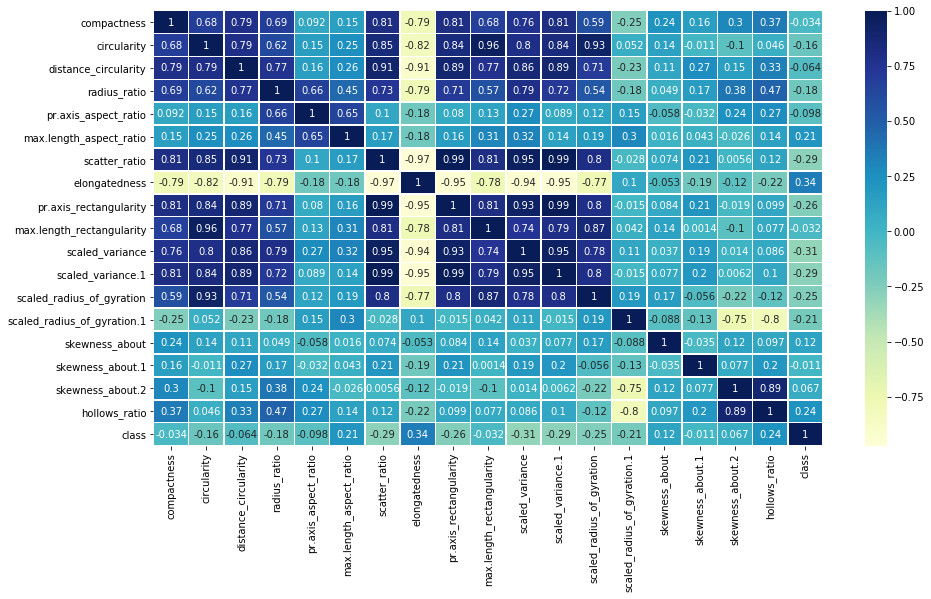

In [11]:
# Finding a correlation b/w columns

plt.figure(figsize=(15,8))

sns.heatmap(df_modified.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=True,
            cmap="YlGnBu")

Observations from above heatmap
* scatter_ratio is highly correlated with compactness, circularity, distance_circularity and radius_ratio
* px.axis_rectangularity is highly correlated with compactness, circularity, distance_circularity and radius_ratio
* max.length_rectangularity is highly correlated with circularity and distance_circularity
* scaled_variance is highly correlated with circularity, distance_circularity and radius_ratio
* scaled_variance.1 is highly correlated with compactness, circularity and distance_circularity
* scaled_radius_of_gyration is highly correlated with circularity
* skewness_about.2 is highly correlated with hollows_ratio

* elongatedness is negatively correlated with distance_circularity, scatter_ratio, px.axis_rectangularity, scaled_variance, scaled_variance.1

In [12]:
print("skewValue of dataframe attributes")
df_modified.skew()

skewValue of dataframe attributes


compactness                    0.381271
circularity                    0.264928
distance_circularity           0.108718
radius_ratio                   0.397572
pr.axis_aspect_ratio           3.835392
max.length_aspect_ratio        6.778394
scatter_ratio                  0.608710
elongatedness                  0.046951
pr.axis_rectangularity         0.774406
max.length_rectangularity      0.256359
scaled_variance                0.655598
scaled_variance.1              0.845345
scaled_radius_of_gyration      0.279910
scaled_radius_of_gyration.1    2.089979
skewness_about                 0.780813
skewness_about.1               0.689014
skewness_about.2               0.249985
hollows_ratio                 -0.226341
class                          0.031106
dtype: float64

### Check outliers

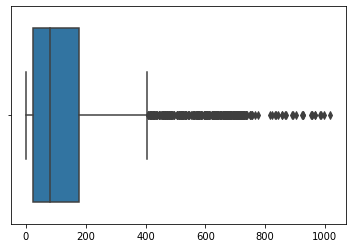

In [13]:
sns.boxplot(df_modified)

In [14]:
def outlier_treatment(df_in, datacolumn):
    sorted(datacolumn)
    #Q1,Q3 = np.percentile(datacolumn , [25,75])
    Q1 = df_in[datacolumn].quantile(0.25)
    Q3 = df_in[datacolumn].quantile(0.75)
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

def handle_outlier(df):
    for feature in df.columns:
        if df.dtypes[feature] != np.object and isinstance(df[feature].dtype, pd.api.types.CategoricalDtype) == False :
            lowerbound,upperbound = outlier_treatment(df, feature) #df[feature])
            print('Feature:%s, outlier length: %s' %(feature, len(df[(df[feature] < lowerbound) | (df[feature] > upperbound)])))
            if(len(df[(df[feature] < lowerbound) | (df[feature] > upperbound)]) > 0):
                df.drop(df[ (df[feature] > upperbound) | (df[feature] < lowerbound) ].index , inplace=True)
    return df
print('Outliers count:')
df_modified = handle_outlier(df_modified)
df_modified.shape

Outliers count:
Feature:compactness, outlier length: 0
Feature:circularity, outlier length: 0
Feature:distance_circularity, outlier length: 0
Feature:radius_ratio, outlier length: 3
Feature:pr.axis_aspect_ratio, outlier length: 5
Feature:max.length_aspect_ratio, outlier length: 5
Feature:scatter_ratio, outlier length: 0
Feature:elongatedness, outlier length: 0
Feature:pr.axis_rectangularity, outlier length: 0
Feature:max.length_rectangularity, outlier length: 0
Feature:scaled_variance, outlier length: 0
Feature:scaled_variance.1, outlier length: 1
Feature:scaled_radius_of_gyration, outlier length: 0
Feature:scaled_radius_of_gyration.1, outlier length: 5
Feature:skewness_about, outlier length: 12
Feature:skewness_about.1, outlier length: 1
Feature:skewness_about.2, outlier length: 0
Feature:hollows_ratio, outlier length: 0
Feature:class, outlier length: 0


(814, 19)

<Figure size 1440x1080 with 0 Axes>

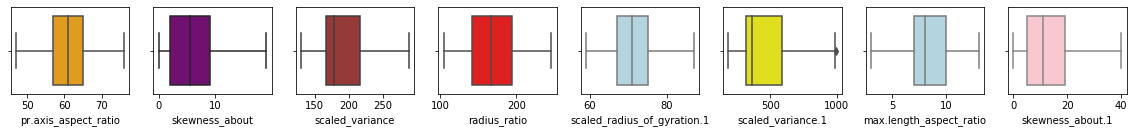

In [15]:

plt.figure(figsize= (20,15))
plt.subplot(8,8,1)
sns.boxplot(x= df_modified['pr.axis_aspect_ratio'], color='orange')

plt.subplot(8,8,2)
sns.boxplot(x= df_modified.skewness_about, color='purple')

plt.subplot(8,8,3)
sns.boxplot(x= df_modified.scaled_variance, color='brown')
plt.subplot(8,8,4)
sns.boxplot(x= df_modified['radius_ratio'], color='red')

plt.subplot(8,8,5)
sns.boxplot(x= df_modified['scaled_radius_of_gyration.1'], color='lightblue')

plt.subplot(8,8,6)
sns.boxplot(x= df_modified['scaled_variance.1'], color='yellow')

plt.subplot(8,8,7)
sns.boxplot(x= df_modified['max.length_aspect_ratio'], color='lightblue')

plt.subplot(8,8,8)
sns.boxplot(x= df_modified['skewness_about.1'], color='pink')

plt.show()

 From above image, we can evidance that outlier has been treated and removed. There is no outlier in the data now

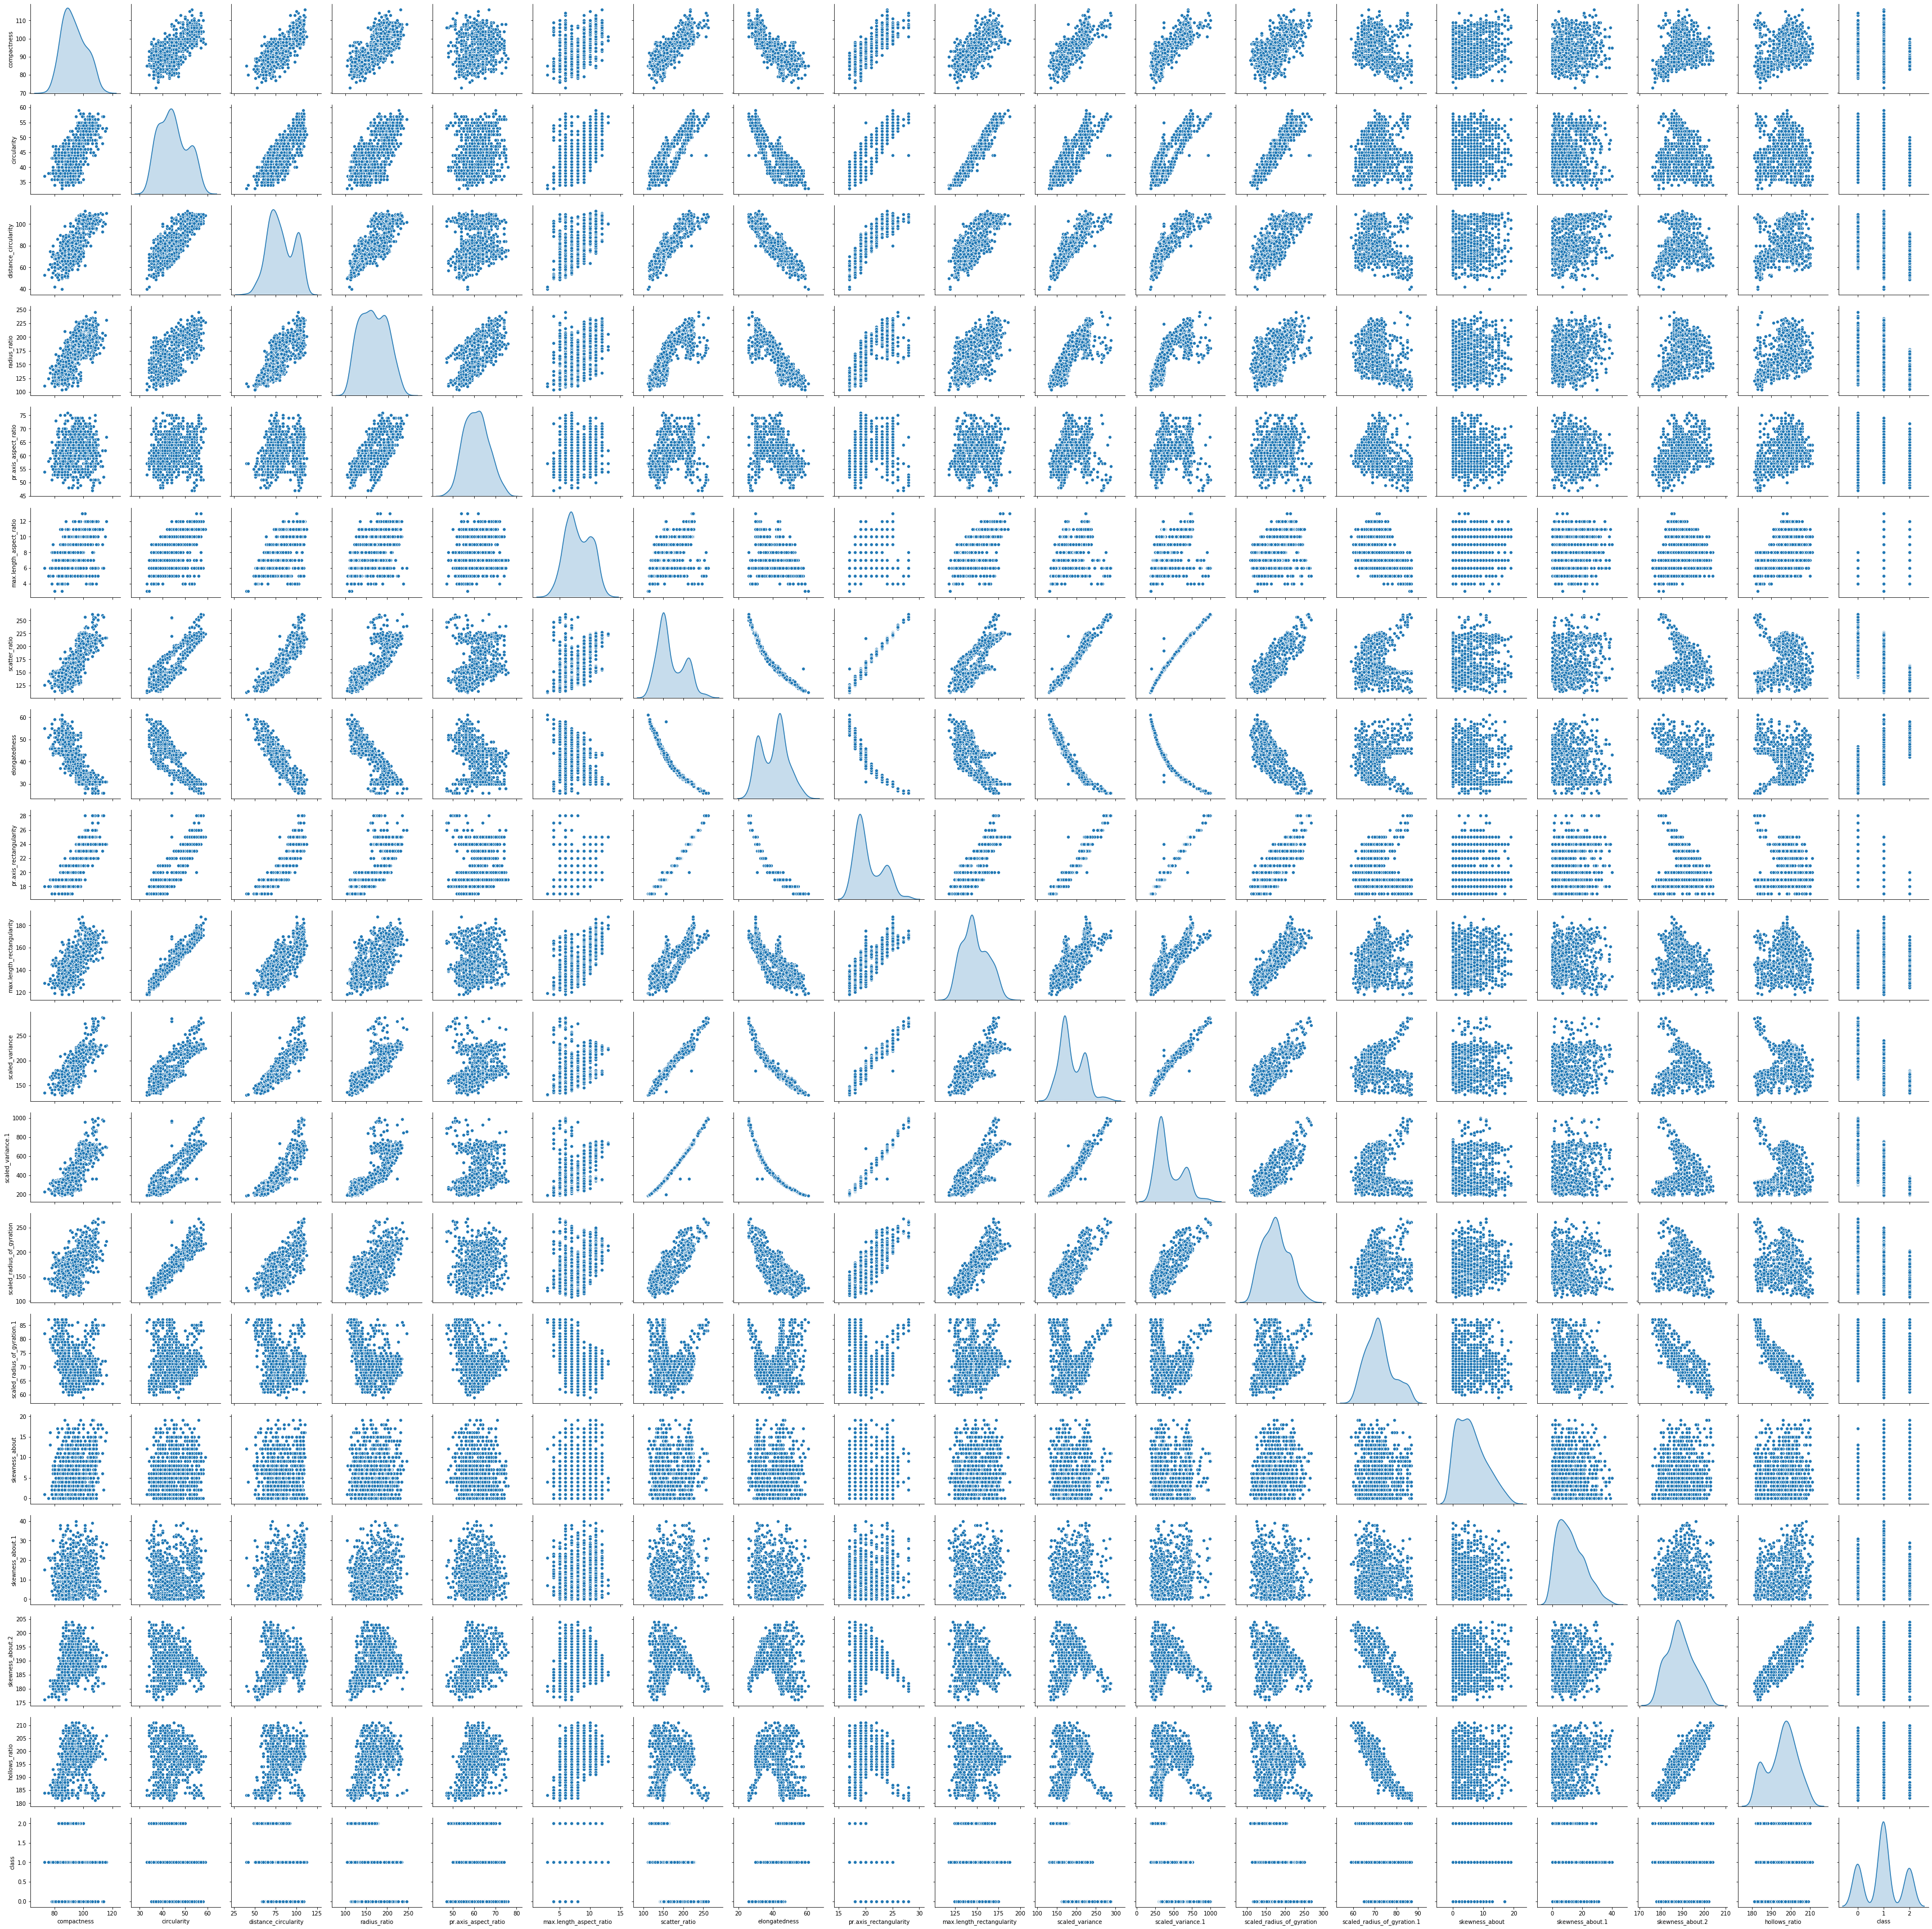

In [16]:
# Pair plot analysis
sns.pairplot(df_modified, diag_kind='kde')

Observations from Pairplot:
* Scaled variance and scaled variance.1 are positively correlated
* Hollow_ratio and skewness_about_2 are positively correlated
* elongatedness and pr.axis_rectangularity are negatively correlated also
* scatter_ratio and elongatedness have very strong negative correlated



In [18]:
def getUnique_Highly_Correlated_Columns(df):
    '''
    Get a list of duplicate columns. and column which has unique data and highly correlated in positively and negatively.
    :param df: Dataframe object
    :return: List of columns which is unwanted (contains unique data or highly correlated).
    '''
    
    unwantedColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        col = df.iloc[:, x]
        x_col_name = df.columns[x]
        if(df[x_col_name].nunique() == 1 or df[x_col_name].nunique() == df.shape[0]): # Remove if All the values in columns are unique
            unwantedColumnNames.add(x_col_name)
        else:
            # Iterate over all the columns in DataFrame from (x+1)th index till end
            for y in range(x + 1, df.shape[1]):
                
                y_col_name = df.columns[y]
                if( (df.dtypes[x_col_name] != np.object) and (df.dtypes[y_col_name] != np.object)):
                    corr = df[x_col_name].corr(df[y_col_name])
                    if math.isnan(corr) == False and ~(-0.90 < corr < 0.85): # Find the correlation between the columns and remove postive and negatively correlated
                        #print(x_col_name,'--',y_col_name,' corr:', corr)
                        unwantedColumnNames.add(x_col_name)
                        break
    
    print('Unwanted columns:', list(unwantedColumnNames))
    return list(unwantedColumnNames)
df_modified = df_modified.drop(columns = getUnique_Highly_Correlated_Columns(df_modified), axis=1)
df_modified.shape

Unwanted columns: ['pr.axis_rectangularity', 'circularity', 'scatter_ratio', 'skewness_about.2', 'scaled_variance', 'elongatedness', 'distance_circularity', 'max.length_rectangularity', 'scaled_radius_of_gyration.1']


(814, 10)

The following columns are highly correlated (-0.90 < corr < 0.85) with other columns. so I dropped it from the dataset.

['scaled_variance', 'scatter_ratio', 'scaled_radius_of_gyration.1', 'max.length_rectangularity', 'skewness_about.2', 'distance_circularity', 'pr.axis_rectangularity', 'circularity', 'elongatedness']

### Data split

In [19]:
# Independent variables
X = df_modified.drop('class', axis=1)
# Dependent variable
y = df_modified[['class']]


## Standardize the data using StandardScaler

In [20]:
sc = StandardScaler()

X_std =  sc.fit_transform(X)   
X_std.shape

(814, 9)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.2, random_state = 10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((651, 9), (163, 9), (651, 1), (163, 1))

#### Covariance Matrix 

In [22]:
# generating the covariance matrix and the eigen values for the PCA analysis
cov_matrix = np.cov(X_std.T) # the relevanat covariance matrix
print('Covariance Matrix \n%s', cov_matrix)

#generating the eigen values and the eigen vectors
e_vals, e_vecs = np.linalg.eig(cov_matrix)
print('Eigenvectors \n%s' %e_vecs)
print('\nEigenvalues \n%s' %e_vals)

Covariance Matrix 
%s [[ 1.00123001  0.74590482  0.19545948  0.49409728  0.81430389  0.58098534
   0.20185344  0.16100329  0.35826024]
 [ 0.74590482  1.00123001  0.66477545  0.46042298  0.7736483   0.55017877
   0.04063041  0.18742357  0.50331063]
 [ 0.19545948  0.66477545  1.00123001  0.14036477  0.17788025  0.14712558
  -0.0528417  -0.02865671  0.42271837]
 [ 0.49409728  0.46042298  0.14036477  1.00123001  0.45120207  0.39966846
   0.0832571   0.14099732  0.39620454]
 [ 0.81430389  0.7736483   0.17788025  0.45120207  1.00123001  0.79269652
   0.06692807  0.20272481  0.09514358]
 [ 0.58098534  0.55017877  0.14712558  0.39966846  0.79269652  1.00123001
   0.17016888 -0.05799646 -0.12581606]
 [ 0.20185344  0.04063041 -0.0528417   0.0832571   0.06692807  0.17016888
   1.00123001 -0.04531115  0.05967049]
 [ 0.16100329  0.18742357 -0.02865671  0.14099732  0.20272481 -0.05799646
  -0.04531115  1.00123001  0.19963042]
 [ 0.35826024  0.50331063  0.42271837  0.39620454  0.09514358 -0.12581606


#### Eigen values

In [23]:
# Make a set of (eigenvalue, eigenvector) pairs:

eig_pairs = [(e_vals[index], e_vecs[:,index]) for index in range(len(e_vals))]

# Sort the (eigenvalue, eigenvector) pairs from highest to lowest with respect to eigenvalue
eig_pairs.sort()

eig_pairs.reverse()
eig_pairs

# Extract the descending ordered eigenvalues and eigenvectors
eigvalues_sorted = [eig_pairs[index][0] for index in range(len(e_vals))]
eigvectors_sorted = [eig_pairs[index][1] for index in range(len(e_vecs))]

# Let's confirm our sorting worked, print out eigenvalues
print('Eigenvalues in descending order: \n%s' %eigvalues_sorted)

[(3.8148358067690813,
  array([-0.44754296, -0.4744118 , -0.23953959, -0.33255789, -0.44867945,
         -0.3634738 , -0.08010597, -0.11152938, -0.2332007 ])),
 (1.5196591984037064,
  array([ 0.11747182, -0.17213653, -0.45786776, -0.03826394,  0.2862627 ,
          0.46499126,  0.21064304, -0.20116536, -0.60204749])),
 (1.0959737938241154,
  array([ 0.10762019, -0.15898925, -0.52063124,  0.21877512,  0.05529539,
         -0.17281719,  0.07248968,  0.77080064,  0.109129  ])),
 (1.025025890265232,
  array([ 0.06900377, -0.09381317, -0.05361102,  0.13450636, -0.207576  ,
         -0.09883399,  0.88163559, -0.23376964,  0.28405273])),
 (0.7415802739156597,
  array([ 0.00495702, -0.17789021, -0.30819769,  0.70954297, -0.09916414,
         -0.01608197, -0.35377941, -0.4391159 ,  0.20449609])),
 (0.4713920517526522,
  array([-0.51916566, -0.04946976,  0.39869759,  0.50498891, -0.15424349,
          0.26032352,  0.16046338,  0.29009437, -0.33553476])),
 (0.2007430732360642,
  array([-0.4357905

Eigenvalues in descending order: 
[3.8148358067690813, 1.5196591984037064, 1.0959737938241154, 1.025025890265232, 0.7415802739156597, 0.4713920517526522, 0.2007430732360642, 0.10776580464582752, 0.03409421788876747]


#### Dimentionality deduction

In [24]:
pca = PCA(n_components=9)
pca.fit(X_train)
pca.explained_variance_
pca.explained_variance_ratio_

PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

array([3.79971324, 1.52688579, 1.05370498, 1.03679307, 0.7724885 ,
       0.4750496 , 0.2010531 , 0.11072227, 0.03260224])

array([0.42176799, 0.16948425, 0.1169612 , 0.11508398, 0.08574619,
       0.05273048, 0.02231688, 0.01229017, 0.00361885])

<BarContainer object of 9 artists>

Text(0, 0.5, 'Variation explained')

Text(0.5, 0, 'eigen Value')

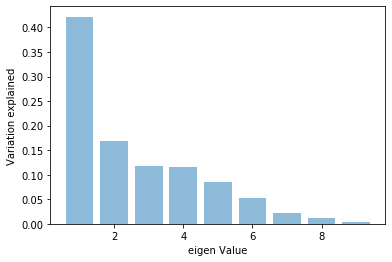

In [25]:
plt.bar(list(range(1,10)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

Text(0, 0.5, 'Cum of variation explained')

Text(0.5, 0, 'eigen Value')

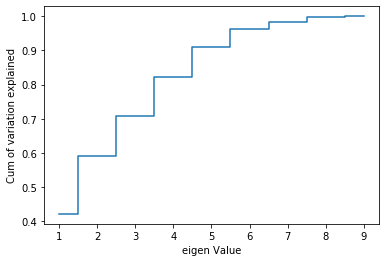

In [26]:
plt.step(list(range(1,10)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

#### Looks like n_component=6 will be the reasonable

### Dimentionality reduction

In [27]:
pca_opt = PCA(n_components=6)
pca_opt.fit(X_train)


PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [28]:
print(pca_opt.components_)
print(pca_opt.explained_variance_ratio_)

[[ 0.4462724   0.4788661   0.24877424  0.32430417  0.44840021  0.36254409
   0.06980188  0.10605001  0.23631869]
 [ 0.11463655 -0.15648282 -0.42818423 -0.06878588  0.30124828  0.47907563
   0.16409558 -0.18152928 -0.62781696]
 [-0.1057434   0.14652294  0.50930288 -0.18434611 -0.05801095  0.14683146
  -0.12736144 -0.78867565 -0.10402631]
 [ 0.07475556 -0.08880786 -0.05487644  0.10869572 -0.1826033  -0.06044497
   0.89958971 -0.26190834  0.23841854]
 [-0.00963532  0.19329137  0.34268778 -0.73761597  0.09176784  0.01038647
   0.31441607  0.39962298 -0.18425028]
 [ 0.51305344  0.0409834  -0.41881336 -0.49153878  0.15028301 -0.25100779
  -0.16764969 -0.29287657  0.34439588]]
[0.42176799 0.16948425 0.1169612  0.11508398 0.08574619 0.05273048]


<BarContainer object of 6 artists>

Text(0, 0.5, 'Variation explained')

Text(0.5, 0, 'eigen Value')

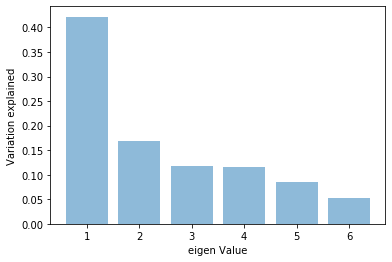

In [29]:
plt.bar(list(range(1,7)),pca_opt.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

In [30]:
# Generating pca test and train
X_train_pca = pca_opt.transform(X_train)
X_test_pca = pca_opt.transform(X_test)
X_train_pca.shape, X_test_pca.shape

((651, 6), (163, 6))

## Logistics Regression

In [31]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("Before PCA score:", logreg.score(X_test, y_test))
      
logreg.fit(X_train_pca, y_train)
print("After PCA score:", logreg.score(X_test_pca, y_test))
      


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Before PCA score: 0.9141104294478528


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

After PCA score: 0.7975460122699386


## RandomForestClassifier

In [32]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print ('Before PCA score', clf.score(X_test, y_test))

clf.fit(X_train_pca, y_train)
print ('After PCA score', clf.score(X_test_pca, y_test))


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Before PCA score 0.9631901840490797


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

After PCA score 0.8957055214723927


## AdaBoostClassifier

In [33]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()
model.fit(X_train, y_train)
print ('Before PCA score', model.score(X_test, y_test))

model.fit(X_train_pca, y_train)
print ('After PCA score', model.score(X_test_pca, y_test))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

Before PCA score 0.8588957055214724


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

After PCA score 0.7791411042944786


## Support vector machine (SVM)

In [34]:
from sklearn.svm import SVC
svm = SVC(C=1, gamma= 0.01, kernel='rbf')
svm.fit(X_train, y_train)
print ('Before PCA score', svm.score(X_test, y_test))

svm.fit(X_train_pca, y_train)
print ('After PCA score', svm.score(X_test_pca, y_test))

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Before PCA score 0.8895705521472392


SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

After PCA score 0.8404907975460123


## Grid SearchCV
Use Grid Search CV to find best hyper parameters 

In [ ]:

# defining parameter range 
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 10, 50],  
              'gamma': [1,  0.1,0.01, 0.001, 0.0001], 
              'kernel': ['linear', 'poly', 'rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

grid.fit(X_train_pca, y_train)


In [36]:
grid.best_params_
print("========================================================")
grid.best_score_
print("========================================================")
grid.best_estimator_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

0.897075748678802

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [37]:
grid_predictions = grid.predict(X_test_pca)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

[[39  0  0]
 [ 2 84  4]
 [ 0  2 32]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        39
           1       0.98      0.93      0.95        90
           2       0.89      0.94      0.91        34

    accuracy                           0.95       163
   macro avg       0.94      0.96      0.95       163
weighted avg       0.95      0.95      0.95       163



## SVM Optimized

In [38]:
# Retrain the model with grid search best parameter

svm_opt = SVC(C=10, gamma= 0.1, kernel='rbf')

svm_opt.fit(X_train_pca, y_train)
print ('Score', svm_opt.score(X_test_pca, y_test))

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Score 0.950920245398773


In [39]:
 # Cross validation scores
scores = cross_val_score(svm_opt,
                         X_train_pca,
                         y_train,
                         cv=5,
                         scoring='r2')

# Get model accuracy
accuracy = svm_opt.score(X_test_pca, y_test)
accuracy

0.950920245398773

#### The performance improved from 84% to 95%

The model is performing well after the PCA dimentionality deduction. 